# Assignment 8

**Course**: AM5801 - Computational Lab  
**Name**: Atharv Shete  
**Roll No**: BE22B021

## Question 1
Determine the specific volume of methane in a 3 m³ tank using the Redlich–Kwong equation of state and a bracketing root-finding method with 2% stopping tolerance.

In [1]:
import math
from typing import Callable, List, Tuple
import pandas as pd

R = 0.518  # kJ/(kg·K)
Tc = 191.0  # K
pc = 4600.0  # kPa
temperature_c = -40.0
T = temperature_c + 273.15  # K
p_target = 65_000.0  # kPa
tank_volume = 3.0  # m³

a = 0.427 * R ** 2 * (Tc ** 2.5) / pc
b = 0.0866 * R * Tc / pc

def redlich_kwong_pressure(v: float) -> float:
    """Evaluate the Redlich–Kwong pressure at specific volume v."""
    term1 = R * T / (v - b)
    term2 = a / (v * (v + b) * math.sqrt(T))
    return term1 - term2

def residual(v: float) -> float:
    return redlich_kwong_pressure(v) - p_target

def bisection(func: Callable[[float], float], lower: float, upper: float, *,
              es_percent: float = 2.0, max_iter: int = 100) -> Tuple[float, List[dict]]:
    """Bisection method with approximate relative-error stopping criterion."""
    f_lower = func(lower)
    f_upper = func(upper)
    if math.isnan(f_lower) or math.isnan(f_upper) or f_lower * f_upper > 0:
        raise ValueError("Bisection bracket must straddle a root without NaNs.")

    history: List[dict] = []
    prev_mid = None

    for iteration in range(1, max_iter + 1):
        mid = 0.5 * (lower + upper)
        f_mid = func(mid)
        if prev_mid is None:
            approx_error = None
        else:
            approx_error = abs((mid - prev_mid) / mid) * 100

        history.append({
            "iteration": iteration,
            "lower": lower,
            "upper": upper,
            "midpoint": mid,
            "residual": f_mid,
            "approx_error_percent": approx_error,
        })

        if f_lower * f_mid < 0:
            upper = mid
            f_upper = f_mid
        else:
            lower = mid
            f_lower = f_mid

        if approx_error is not None and approx_error < es_percent:
            break

        prev_mid = mid

    return mid, history

initial_lower = 0.0
initial_upper = 2.0
v_lower = max(b * 1.001, initial_lower + 1e-6)
v_upper = initial_upper

root_volume, iteration_records = bisection(residual, v_lower, v_upper)
mass_methane = tank_volume / root_volume
pressure_check = redlich_kwong_pressure(root_volume)

iteration_table = pd.DataFrame(iteration_records)
final_error = iteration_table["approx_error_percent"].dropna().iloc[-1]

print(f"Computed specific volume: {root_volume:.6f} m³/kg")
print(f"Methane mass in tank: {mass_methane:.3f} kg")
print(f"Pressure consistency check: {pressure_check:.1f} kPa")
print(f"Final approximate relative error: {final_error:.2f}%")

iteration_table

Computed specific volume: 0.002810 m³/kg
Methane mass in tank: 1067.752 kg
Pressure consistency check: 64877.9 kPa
Final approximate relative error: 1.09%


,iteration,lower,upper,midpoint,residual,approx_error_percent
0,1,0.001864,2.000000,1.000932,-64879.935199,NaN
1,2,0.001864,1.000932,0.501398,-64761.491376,99.628144
2,3,0.001864,0.501398,0.251631,-64529.359291,99.259044
3,4,0.001864,0.251631,0.126748,-64083.391198,98.528988
4,5,0.001864,0.126748,0.064306,-63259.188281,97.100625
5,6,0.001864,0.064306,0.033085,-61843.205530,94.364641
6,7,0.001864,0.033085,0.017475,-59698.090779,89.330544
7,8,0.001864,0.017475,0.009670,-56905.559868,80.718337
8,9,0.001864,0.009670,0.005767,-52759.302528,67.670365
9,10,0.001864,0.005767,0.003816,-41122.690605,51.137725


## Question 2
Apply the Newton–Raphson method to the Colebrook–White equation to estimate the Darcy friction factor for turbulent flow in a smooth pipe, stopping when the approximate relative error is below 0.1%, and compare with the explicit correlation.

In [2]:
import math
import pandas as pd

D = 0.05  # m
epsilon = 0.00015  # m
Re = 2.0e5
f_initial = 0.02
tolerance_percent = 0.1

relative_roughness = epsilon / D

def colebrook_residual(f: float) -> float:
    term = (relative_roughness / 3.7) + (2.51 / (Re * math.sqrt(f)))
    return 1.0 / math.sqrt(f) + 2.0 * math.log10(term)

def colebrook_derivative(f: float) -> float:
    term = (relative_roughness / 3.7) + (2.51 / (Re * math.sqrt(f)))
    dterm_df = -2.51 / (2 * Re) * f ** (-1.5)
    return -0.5 * f ** (-1.5) + (2.0 / math.log(10.0)) * (dterm_df / term)

def newton_raphson(f0: float, tol_percent: float, max_iter: int = 50):
    history = []
    f_current = f0

    for iteration in range(1, max_iter + 1):
        residual_value = colebrook_residual(f_current)
        derivative_value = colebrook_derivative(f_current)
        if derivative_value == 0:
            raise ZeroDivisionError("Derivative became zero during iterations.")

        f_next = f_current - residual_value / derivative_value
        approx_error = abs((f_next - f_current) / f_next) * 100

        history.append({
            "iteration": iteration,
            "friction_factor": f_next,
            "approx_error_percent": approx_error,
        })

        f_current = f_next
        if approx_error < tol_percent:
            break

    return f_current, history

friction_factor, nr_history = newton_raphson(f_initial, tolerance_percent)
history_table = pd.DataFrame(nr_history)

explicit_f = 0.25 / (math.log10((relative_roughness / 3.7) + (5.74 / (Re ** 0.9)))) ** 2
difference_percent = abs(friction_factor - explicit_f) / explicit_f * 100

print(f"Newton–Raphson friction factor: {friction_factor:.6f}")
print(f"Explicit correlation friction factor: {explicit_f:.6f}")
print(f"Percent difference: {difference_percent:.3f}%")

history_table

Newton–Raphson friction factor: 0.026841
Explicit correlation friction factor: 0.027018
Percent difference: 0.654%


,iteration,friction_factor,approx_error_percent
0,1,0.025472,21.483738
1,2,0.026789,4.913486
2,3,0.026841,0.196451
3,4,0.026841,0.000290


## Question 3
Quantify the maximum interpolation error when approximating $y = x^2$ on $[0, 10]$ with piecewise linear segments formed from equally spaced data points, and study how the maximum error changes as the data density varies.

n_interior = 4 (segments = 5)


,segment,x_start,x_end,midpoint,signed_error,max_abs_error
0,1,0.0,2.0,1.0,-1.0,1.0
1,2,2.0,4.0,3.0,-1.0,1.0
2,3,4.0,6.0,5.0,-1.0,1.0
3,4,6.0,8.0,7.0,-1.0,1.0
4,5,8.0,10.0,9.0,-1.0,1.0


n_interior = 6 (segments = 7)


,segment,x_start,x_end,midpoint,signed_error,max_abs_error
0,1,0.000000,1.428571,0.714286,-0.510204,0.510204
1,2,1.428571,2.857143,2.142857,-0.510204,0.510204
2,3,2.857143,4.285714,3.571429,-0.510204,0.510204
3,4,4.285714,5.714286,5.000000,-0.510204,0.510204
4,5,5.714286,7.142857,6.428571,-0.510204,0.510204
5,6,7.142857,8.571429,7.857143,-0.510204,0.510204
6,7,8.571429,10.000000,9.285714,-0.510204,0.510204


n_interior = 8 (segments = 9)


,segment,x_start,x_end,midpoint,signed_error,max_abs_error
0,1,0.000000,1.111111,0.555556,-0.308642,0.308642
1,2,1.111111,2.222222,1.666667,-0.308642,0.308642
2,3,2.222222,3.333333,2.777778,-0.308642,0.308642
3,4,3.333333,4.444444,3.888889,-0.308642,0.308642
4,5,4.444444,5.555556,5.000000,-0.308642,0.308642
5,6,5.555556,6.666667,6.111111,-0.308642,0.308642
6,7,6.666667,7.777778,7.222222,-0.308642,0.308642
7,8,7.777778,8.888889,8.333333,-0.308642,0.308642
8,9,8.888889,10.000000,9.444444,-0.308642,0.308642


n_interior = 10 (segments = 11)


,segment,x_start,x_end,midpoint,signed_error,max_abs_error
0,1,0.000000,0.909091,0.454545,-0.206612,0.206612
1,2,0.909091,1.818182,1.363636,-0.206612,0.206612
2,3,1.818182,2.727273,2.272727,-0.206612,0.206612
3,4,2.727273,3.636364,3.181818,-0.206612,0.206612
4,5,3.636364,4.545455,4.090909,-0.206612,0.206612
5,6,4.545455,5.454545,5.000000,-0.206612,0.206612
6,7,5.454545,6.363636,5.909091,-0.206612,0.206612
7,8,6.363636,7.272727,6.818182,-0.206612,0.206612
8,9,7.272727,8.181818,7.727273,-0.206612,0.206612
9,10,8.181818,9.090909,8.636364,-0.206612,0.206612


n_interior = 12 (segments = 13)


,segment,x_start,x_end,midpoint,signed_error,max_abs_error
0,1,0.000000,0.769231,0.384615,-0.147929,0.147929
1,2,0.769231,1.538462,1.153846,-0.147929,0.147929
2,3,1.538462,2.307692,1.923077,-0.147929,0.147929
3,4,2.307692,3.076923,2.692308,-0.147929,0.147929
4,5,3.076923,3.846154,3.461538,-0.147929,0.147929
5,6,3.846154,4.615385,4.230769,-0.147929,0.147929
6,7,4.615385,5.384615,5.000000,-0.147929,0.147929
7,8,5.384615,6.153846,5.769231,-0.147929,0.147929
8,9,6.153846,6.923077,6.538462,-0.147929,0.147929
9,10,6.923077,7.692308,7.307692,-0.147929,0.147929


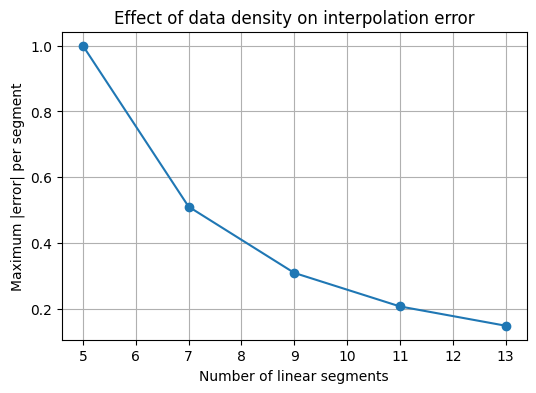

,interior_points,segments,max_abs_error
0,4,5,1.000000
1,6,7,0.510204
2,8,9,0.308642
3,10,11,0.206612
4,12,13,0.147929


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

def segment_error_table(n_interior: int) -> pd.DataFrame:
    """Compute max interpolation error per segment for n interior points."""
    if n_interior <= 0:
        raise ValueError("Number of interior points must be positive.")

    x_nodes = np.linspace(0.0, 10.0, n_interior + 2)  # includes endpoints
    records = []

    for idx in range(len(x_nodes) - 1):
        x0 = x_nodes[idx]
        x1 = x_nodes[idx + 1]
        midpoint = 0.5 * (x0 + x1)
        slope = x0 + x1
        interpolant_mid = x0 ** 2 + slope * (midpoint - x0)
        true_mid = midpoint ** 2
        mid_error = true_mid - interpolant_mid
        records.append({
            "segment": idx + 1,
            "x_start": x0,
            "x_end": x1,
            "midpoint": midpoint,
            "signed_error": mid_error,
            "max_abs_error": abs(mid_error),
        })

    return pd.DataFrame(records)

base_interior_points = 8
offsets = [-4, -2, 0, 2, 4]
interior_values = [base_interior_points + offset for offset in offsets if base_interior_points + offset > 0]

segment_tables = {}
summary_rows = []
for n_interior in interior_values:
    segment_df = segment_error_table(n_interior)
    segment_tables[n_interior] = segment_df
    summary_rows.append({
        "interior_points": n_interior,
        "segments": n_interior + 1,
        "max_abs_error": segment_df["max_abs_error"].max(),
    })

for n_interior, table in segment_tables.items():
    print(f"n_interior = {n_interior} (segments = {n_interior + 1})")
    display(table)

summary_df = pd.DataFrame(summary_rows).sort_values("segments")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(summary_df["segments"], summary_df["max_abs_error"], marker="o")
ax.set_xlabel("Number of linear segments")
ax.set_ylabel("Maximum |error| per segment")
ax.set_title("Effect of data density on interpolation error")
ax.grid(True)
plt.show()

summary_df